# BBC News Text Classification with Neural Networks

Multi-class text classification using the BBC News dataset with 5 categories:
- Business (510 articles)
- Entertainment (386 articles)
- Politics (417 articles)
- Sport (511 articles)
- Tech (401 articles)

We will use Neural Networks (Traditional, CNN, RNN, LSTM) to train and predict.

In [1]:
# Load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import string
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avo9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load BBC News Dataset

The BBC dataset contains 2,225 news articles in 5 categories.

**File format:** Tab-separated (\t) with columns: category, filename, title, content

In [2]:
# Read the tab-separated CSV file
df = pd.read_csv('Data/bbc-news-data.csv', sep='\t')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset shape: (2225, 4)

Columns: ['category', 'filename', 'title', 'content']


,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


## Data Exploration

In [3]:
df.shape

(2225, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


In [5]:
# Check class distribution
print("Class Distribution:")
print(df['category'].value_counts())
print("\nPercentage:")
print((df['category'].value_counts(normalize=True) * 100).round(2))

Class Distribution:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

Percentage:
category
sport            22.97
business         22.92
politics         18.74
tech             18.02
entertainment    17.35
Name: proportion, dtype: float64


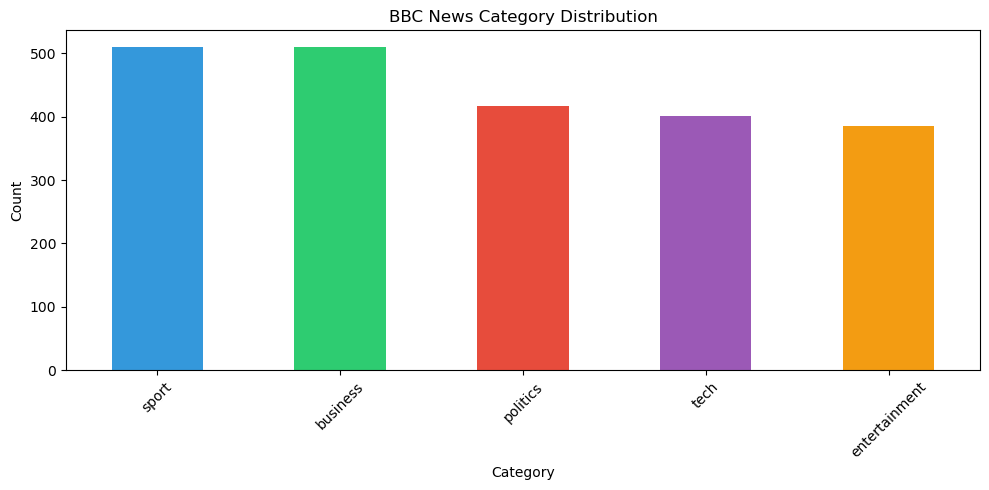

In [6]:
# Visualize class distribution
plt.figure(figsize=(10, 5))
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']
df['category'].value_counts().plot(kind='bar', color=colors)
plt.title('BBC News Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Create label encoding
label_mapping = {label: idx for idx, label in enumerate(sorted(df['category'].unique()))}
reverse_mapping = {idx: label for label, idx in label_mapping.items()}

print("Label Mapping:")
for label, idx in label_mapping.items():
    print(f"  {idx}: {label}")

df['label'] = df['category'].map(label_mapping)
num_classes = len(label_mapping)
print(f"\nNumber of classes: {num_classes}")

Label Mapping:
  0: business
  1: entertainment
  2: politics
  3: sport
  4: tech

Number of classes: 5


In [8]:
# Sample text from each category
for category in df['category'].unique():
    sample = df[df['category'] == category]['content'].iloc[0][:300]
    title = df[df['category'] == category]['title'].iloc[0]
    print(f"\n{'='*60}")
    print(f"{category.upper()}")
    print(f"Title: {title}")
    print(f"{'='*60}")
    print(f"{sample}...")


BUSINESS
Title: Ad sales boost Time Warner profit
 Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.  The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fo...

ENTERTAINMENT
Title: Gallery unveils interactive tree
 A Christmas tree that can receive text messages has been unveiled at London's Tate Britain art gallery.  The spruce has an antenna which can receive Bluetooth texts sent by visitors to the Tate. The messages will be "unwrapped" by sculptor Richard Wentworth, who is responsible for decorating the tr...

POLITICS
Title: Labour plans maternity pay rise
 Maternity pay for new mothers is to rise by £1,400 as part of new proposals announced by the Trade and Industry Secretary Patricia Hewitt.  It would mean paid leave would be increased to nine months by 2007, Ms Hewitt told GMTV's Sunday

## Data Preprocessing

In [9]:
# Text cleaning function
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply cleaning to content column
df['clean_text'] = df['content'].apply(clean_text)
df[['category', 'title', 'clean_text']].head()

,category,title,clean_text
0,business,Ad sales boost Time Warner profit,quarterly profits us media giant timewarner ju...
1,business,Dollar gains on Greenspan speech,dollar hit highest level euro almost three mon...
2,business,Yukos unit buyer faces loan claim,owners embattled russian oil giant yukos ask b...
3,business,High fuel prices hit BA's profits,british airways blamed high fuel prices drop p...
4,business,Pernod takeover talk lifts Domecq,shares uk drinks food firm allied domecq risen...


Text Length Statistics (words):
count    2225.000000
mean      212.753258
std       125.948958
min        44.000000
25%       136.000000
50%       186.000000
75%       263.000000
max      2212.000000
Name: text_length, dtype: float64


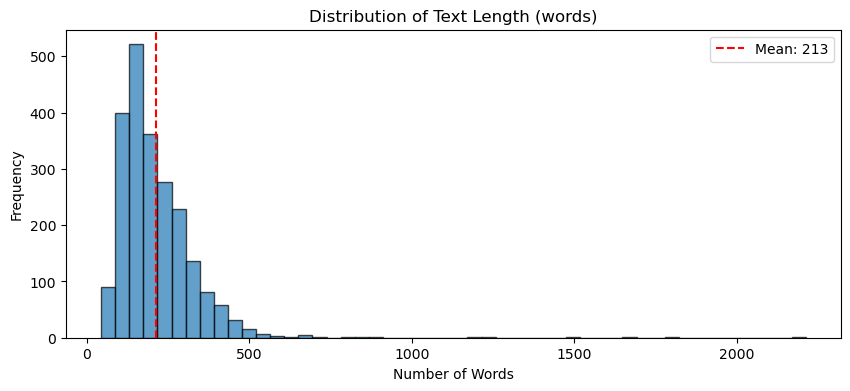

In [10]:
# Check text length distribution
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

print("Text Length Statistics (words):")
print(df['text_length'].describe())

plt.figure(figsize=(10, 4))
plt.hist(df['text_length'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Text Length (words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.axvline(df['text_length'].mean(), color='red', linestyle='--', label=f"Mean: {df['text_length'].mean():.0f}")
plt.legend()
plt.show()

## Modeling

Steps:
1. Split data into train and test (75/25)
2. Vectorize text using CountVectorizer
3. Train neural network models
4. Evaluate performance

In [11]:
# Step 1: Train-test split
X = df['clean_text']
y = df['label']

print(f"X shape: {X.shape}, y shape: {y.shape}")

# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Check distribution in splits
print(f"\nTraining class distribution:")
for idx in sorted(y_train.unique()):
    count = sum(y_train == idx)
    print(f"  {reverse_mapping[idx]}: {count}")

X shape: (2225,), y shape: (2225,)

Training set: 1668 samples
Test set: 557 samples

Training class distribution:
  business: 382
  entertainment: 289
  politics: 313
  sport: 383
  tech: 301


In [12]:
# Step 2-3: Vectorize text
vect = CountVectorizer(max_features=10000, preprocessor=clean_text)
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

print(f"Vocabulary size: {len(vect.vocabulary_)}")
print(f"Training DTM shape: {X_train_dtm.shape}")
print(f"Test DTM shape: {X_test_dtm.shape}")

Vocabulary size: 10000
Training DTM shape: (1668, 10000)
Test DTM shape: (557, 10000)


## Neural Network Setup

**GPU Setup:** Runtime > Change runtime type > T4 GPU

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import pad_sequences, to_categorical

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

c:\Users\avo9\AppData\Local\anaconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\avo9\AppData\Local\anaconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\avo9\AppData\Local\anaconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode

TensorFlow version: 2.20.0
GPU available: []


In [14]:
# Pad sequences for neural network input
max_len = 5000  # Maximum sequence length

X_train_dense = pad_sequences(X_train_dtm.toarray(), maxlen=max_len, padding='post', truncating='post')
X_test_dense = pad_sequences(X_test_dtm.toarray(), maxlen=max_len, padding='post', truncating='post')

print(f"X_train_dense shape: {X_train_dense.shape}")
print(f"X_test_dense shape: {X_test_dense.shape}")

X_train_dense shape: (1668, 5000)
X_test_dense shape: (557, 5000)


In [15]:
# Convert labels to categorical (one-hot encoding) for multi-class
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print(f"y_train_cat shape: {y_train_cat.shape}")
print(f"y_test_cat shape: {y_test_cat.shape}")
print(f"\nSample one-hot label: {y_train_cat[0]} -> {reverse_mapping[np.argmax(y_train_cat[0])]}")

y_train_cat shape: (1668, 5)
y_test_cat shape: (557, 5)

Sample one-hot label: [0. 0. 0. 1. 0.] -> sport


## Model 1: Classic Neural Network (Dense Layers)

In [16]:
# Define the neural network model for multi-class classification
model_dense = keras.Sequential([
    keras.layers.Embedding(input_dim=X_train_dense.shape[1], output_dim=64),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class
])

# Compile with categorical crossentropy for multi-class
model_dense.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_dense.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Train the model
history_dense = model_dense.fit(
    X_train_dense, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_dense, y_test_cat),
    verbose=1
)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.2182 - loss: 2.7819 - val_accuracy: 0.2298 - val_loss: 2.3486
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.2344 - loss: 2.1288 - val_accuracy: 0.2298 - val_loss: 1.9373
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.2248 - loss: 1.8389 - val_accuracy: 0.2316 - val_loss: 1.7538
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.2302 - loss: 1.7112 - val_accuracy: 0.2298 - val_loss: 1.6732
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.2224 - loss: 1.6553 - val_accuracy: 0.2298 - val_loss: 1.6381
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2362 - loss: 1.6288 - val_accuracy: 0.2298 - val_loss: 1.6217
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.2158 - loss: 1.6192 - val_accuracy: 0.2298 - val_loss: 1.6133
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.2398 - loss: 1.6119 - val_accuracy: 0.2298 - v

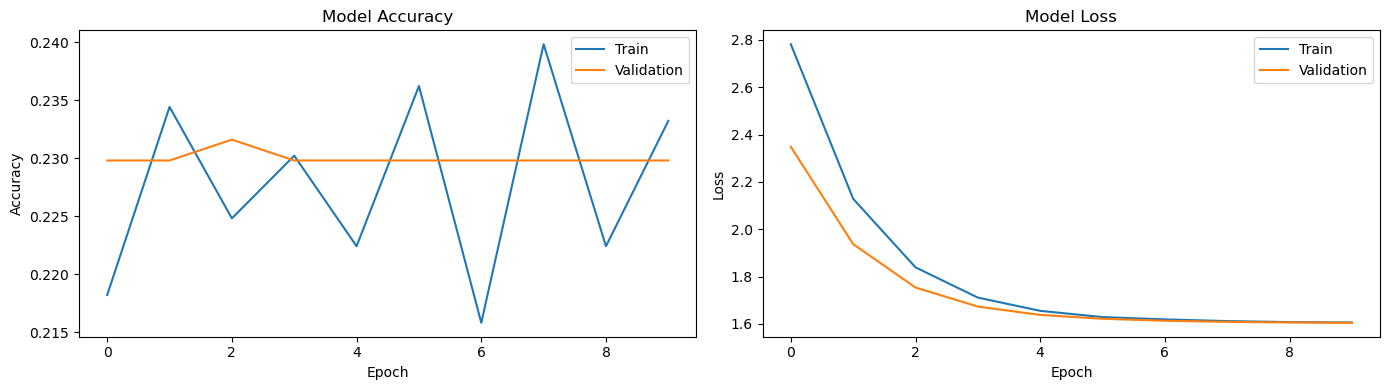

In [18]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Accuracy
axes[0].plot(history_dense.history['accuracy'], label='Train')
axes[0].plot(history_dense.history['val_accuracy'], label='Validation')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss
axes[1].plot(history_dense.history['loss'], label='Train')
axes[1].plot(history_dense.history['val_loss'], label='Validation')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

In [19]:
# Evaluate Model 1
loss, accuracy = model_dense.evaluate(X_test_dense, y_test_cat)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Get predictions
predictions_dense = model_dense.predict(X_test_dense)
predicted_classes_dense = np.argmax(predictions_dense, axis=1)

print("\n" + "="*50)
print("Model 1: Dense Neural Network")
print("="*50)
print(classification_report(y_test, predicted_classes_dense, target_names=sorted(label_mapping.keys())))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2298 - loss: 1.6047
Test Loss: 1.6047
Test Accuracy: 0.2298
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Model 1: Dense Neural Network
               precision    recall  f1-score   support

     business       0.00      0.00      0.00       128
entertainment       0.00      0.00      0.00        97
     politics       0.00      0.00      0.00       104
        sport       0.23      1.00      0.37       128
         tech       0.00      0.00      0.00       100

     accuracy                           0.23       557
    macro avg       0.05      0.20      0.07       557
 weighted avg       0.05      0.23      0.09       557



c:\Users\avo9\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\avo9\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\avo9\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


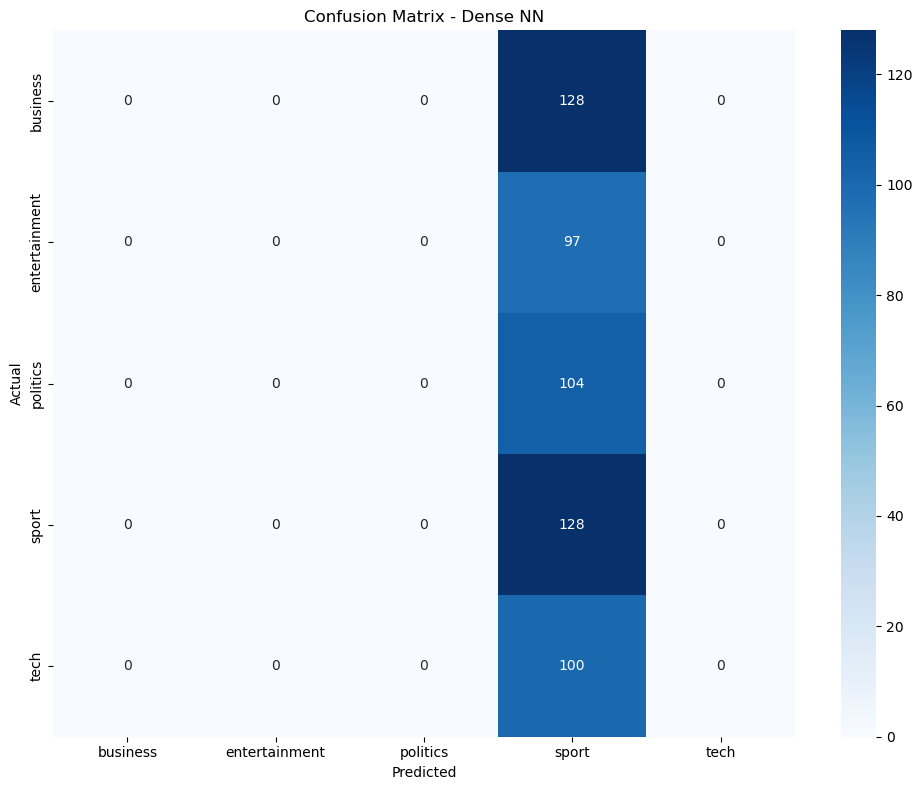

In [20]:
# Confusion Matrix
import seaborn as sns

cm = confusion_matrix(y_test, predicted_classes_dense)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(label_mapping.keys()),
            yticklabels=sorted(label_mapping.keys()))
plt.title('Confusion Matrix - Dense NN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## Model 2: CNN (Convolutional Neural Network)

In [21]:
# CNN Model for text classification
model_cnn = keras.Sequential([
    keras.layers.Embedding(input_dim=X_train_dense.shape[1], output_dim=128),
    keras.layers.Conv1D(128, 5, activation='relu'),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(num_classes, activation='softmax')
])

model_cnn.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train CNN
history_cnn = model_cnn.fit(
    X_train_dense, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_dense, y_test_cat),
    verbose=1
)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 37s 671ms/step - accuracy: 0.2494 - loss: 1.6037 - val_accuracy: 0.2478 - val_loss: 1.5893
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 35s 662ms/step - accuracy: 0.2770 - loss: 1.5742 - val_accuracy: 0.2747 - val_loss: 1.5600
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 610ms/step - accuracy: 0.2998 - loss: 1.5456 - val_accuracy: 0.2944 - val_loss: 1.5400
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 611ms/step - accuracy: 0.3118 - loss: 1.5271 - val_accuracy: 0.3178 - val_loss: 1.5346
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 582ms/step - accuracy: 0.3327 - loss: 1.5110 - val_accuracy: 0.2998 - val_loss: 1.5304
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 582ms/step - accuracy: 0.3573 - loss: 1.4983 - val_accuracy: 0.3088 - val_loss: 1.5188
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 602ms/step - accuracy: 0.3363 - loss: 1.4995 - val_accuracy: 0.3178 - val_loss: 1.5148
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 606ms/step - accuracy: 0.3537 - loss: 1.4776 - val_accu

In [23]:
# Evaluate CNN
predictions_cnn = model_cnn.predict(X_test_dense)
predicted_classes_cnn = np.argmax(predictions_cnn, axis=1)

print("="*50)
print("Model 2: CNN")
print("="*50)
print(classification_report(y_test, predicted_classes_cnn, target_names=sorted(label_mapping.keys())))

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
Model 2: CNN
               precision    recall  f1-score   support

     business       0.30      0.35      0.32       128
entertainment       0.33      0.02      0.04        97
     politics       0.27      0.29      0.28       104
        sport       0.36      0.60      0.45       128
         tech       0.41      0.31      0.35       100

     accuracy                           0.33       557
    macro avg       0.33      0.31      0.29       557
 weighted avg       0.33      0.33      0.30       557



## Model 3: LSTM (Long Short-Term Memory)

In [24]:
# LSTM Model
model_lstm = keras.Sequential([
    keras.layers.Embedding(input_dim=X_train_dense.shape[1], output_dim=128),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Train LSTM
history_lstm = model_lstm.fit(
    X_train_dense, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_dense, y_test_cat),
    verbose=1
)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.2278 - loss: 1.6070 - val_accuracy: 0.2298 - val_loss: 1.6054
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.2278 - loss: 1.6043 - val_accuracy: 0.2298 - val_loss: 1.6034
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.2206 - loss: 1.6059 - val_accuracy: 0.2298 - val_loss: 1.6032
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.2200 - loss: 1.6046 - val_accuracy: 0.2298 - val_loss: 1.6009
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.2248 - loss: 1.6031 - val_accuracy: 0.2513 - val_loss: 1.5969
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 139s 3s/step - accuracy: 0.2686 - loss: 1.6504 - val_accuracy: 0.2783 - val_loss: 1.6075
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.2230 - loss: 1.6260 - val_accuracy: 0.2298 - val_loss: 1.6113
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.2296 - loss: 1.6255 - val_accuracy: 0.2011 - v

In [26]:
# Evaluate LSTM
predictions_lstm = model_lstm.predict(X_test_dense)
predicted_classes_lstm = np.argmax(predictions_lstm, axis=1)

print("="*50)
print("Model 3: LSTM")
print("="*50)
print(classification_report(y_test, predicted_classes_lstm, target_names=sorted(label_mapping.keys())))

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 489ms/step
Model 3: LSTM
               precision    recall  f1-score   support

     business       0.23      0.32      0.27       128
entertainment       0.00      0.00      0.00        97
     politics       0.20      0.65      0.31       104
        sport       0.11      0.03      0.05       128
         tech       0.00      0.00      0.00       100

     accuracy                           0.20       557
    macro avg       0.11      0.20      0.12       557
 weighted avg       0.11      0.20      0.13       557



c:\Users\avo9\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\avo9\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\avo9\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Model 4: Bidirectional LSTM

In [27]:
# Bidirectional LSTM Model
model_bilstm = keras.Sequential([
    keras.layers.Embedding(input_dim=X_train_dense.shape[1], output_dim=128),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])

model_bilstm.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_bilstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train Bidirectional LSTM
history_bilstm = model_bilstm.fit(
    X_train_dense, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_dense, y_test_cat),
    verbose=1
)

Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 495s 9s/step - accuracy: 0.2326 - loss: 1.6074 - val_accuracy: 0.2298 - val_loss: 1.6018
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 492s 9s/step - accuracy: 0.2266 - loss: 1.6054 - val_accuracy: 0.2298 - val_loss: 1.6018
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 465s 9s/step - accuracy: 0.2248 - loss: 1.6046 - val_accuracy: 0.2298 - val_loss: 1.6021
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 439s 8s/step - accuracy: 0.2242 - loss: 1.6046 - val_accuracy: 0.2316 - val_loss: 1.6042
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 502s 9s/step - accuracy: 0.2332 - loss: 1.6047 - val_accuracy: 0.2298 - val_loss: 1.6019
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 433s 8s/step - accuracy: 0.2224 - loss: 1.6041 - val_accuracy: 0.2298 - val_loss: 1.6013
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 399s 8s/step - accuracy: 0.2284 - loss: 1.6011 - val_accuracy: 0.2316 - val_loss: 1.5979
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 419s 8s/step - accuracy: 0.2848 - loss: 1.5628 - val_accuracy: 0.3088 - v

In [29]:
# Evaluate Bidirectional LSTM
predictions_bilstm = model_bilstm.predict(X_test_dense)
predicted_classes_bilstm = np.argmax(predictions_bilstm, axis=1)

print("="*50)
print("Model 4: Bidirectional LSTM")
print("="*50)
print(classification_report(y_test, predicted_classes_bilstm, target_names=sorted(label_mapping.keys())))

18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 677ms/step
Model 4: Bidirectional LSTM
               precision    recall  f1-score   support

     business       0.11      0.02      0.03       128
entertainment       0.00      0.00      0.00        97
     politics       0.55      0.51      0.53       104
        sport       0.27      0.92      0.41       128
         tech       0.00      0.00      0.00       100

     accuracy                           0.31       557
    macro avg       0.18      0.29      0.19       557
 weighted avg       0.19      0.31      0.20       557



c:\Users\avo9\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\avo9\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\avo9\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Model Comparison

Model Comparison:
   Model  Accuracy
     CNN  0.332136
 Bi-LSTM  0.310592
Dense NN  0.229803
    LSTM  0.202873


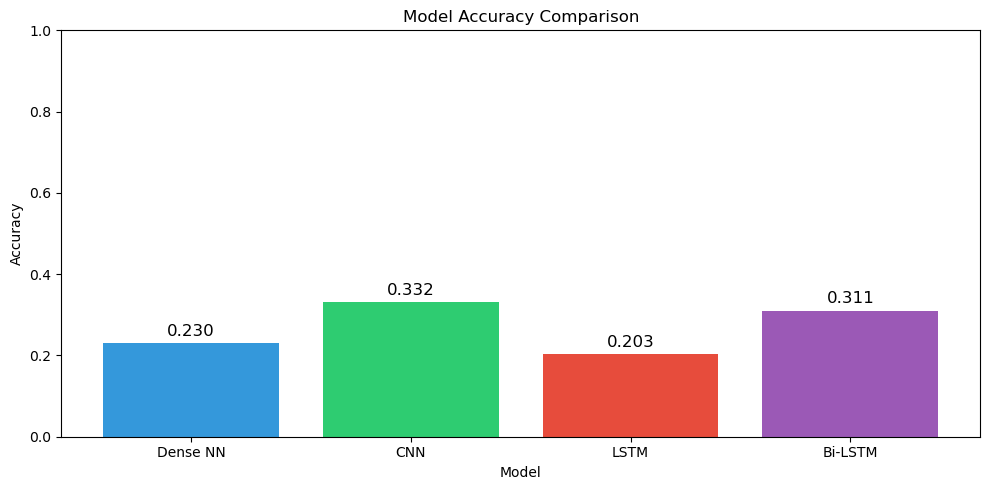

In [30]:
# Compare all models
models = ['Dense NN', 'CNN', 'LSTM', 'Bi-LSTM']
predictions_all = [predicted_classes_dense, predicted_classes_cnn, predicted_classes_lstm, predicted_classes_bilstm]

accuracies = [accuracy_score(y_test, pred) for pred in predictions_all]

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies
}).sort_values('Accuracy', ascending=False)

print("Model Comparison:")
print(comparison_df.to_string(index=False))

# Visualization
plt.figure(figsize=(10, 5))
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']
bars = plt.bar(models, accuracies, color=colors)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

## Key Takeaways

| Model | Best For |
|-------|----------|
| **Dense NN** | Fast training, baseline performance |
| **CNN** | Capturing local patterns in text |
| **LSTM** | Sequential dependencies |
| **Bi-LSTM** | Context from both directions |

### Multi-class Classification Notes:
- Use `softmax` activation (not sigmoid) for output layer
- Use `categorical_crossentropy` loss (not binary)
- Convert labels to one-hot encoding with `to_categorical()`
- Use `np.argmax()` to get predicted classes from probabilities
- Evaluate with macro F1 for balanced assessment across classes

### BBC Dataset Summary:
- **Total articles:** 2,225
- **Categories:** business, entertainment, politics, sport, tech
- **File format:** Tab-separated CSV with columns: category, filename, title, content